# –ü—Ä–∞–∫—Ç–∏—á–µ—Å–∫–∞—è —Ä–∞–±–æ—Ç–∞ ‚Ññ3

### –ì–æ–ø–∏–µ–Ω–∫–æ –ê–ª–µ–∫—Å–∞–Ω–¥—Ä –î–º–∏—Ç—Ä–∏–µ–≤–∏—á –ö–ò22-17/2–ë

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

### 1) –°—á–∏—Ç—ã–≤–∞–µ–º –¥–∞–Ω–Ω—ã–µ

In [2]:
data_dir = "PH2 Dataset images"
selected_dirs = [d for d in os.listdir(data_dir) if d.startswith("IMD")] 

image_paths = []
mask_paths = []

for dir_name in selected_dirs:
    dir_path = os.path.join(data_dir, dir_name)
    sub_dirs = os.listdir(dir_path)  

    derm_path = os.path.join(dir_path, f"{dir_name}_Dermoscopic_Image")
    lesion_path = os.path.join(dir_path, f"{dir_name}_lesion")

    if os.path.exists(derm_path) and os.path.exists(lesion_path):
        image_paths.extend(sorted(glob.glob(os.path.join(derm_path, "*.bmp"))))
        mask_paths.extend(sorted(glob.glob(os.path.join(lesion_path, "*.bmp"))))

print(f"–ù–∞–π–¥–µ–Ω–æ {len(image_paths)} –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –∏ {len(mask_paths)} –º–∞—Å–æ–∫.")

–ù–∞–π–¥–µ–Ω–æ 200 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –∏ 200 –º–∞—Å–æ–∫.


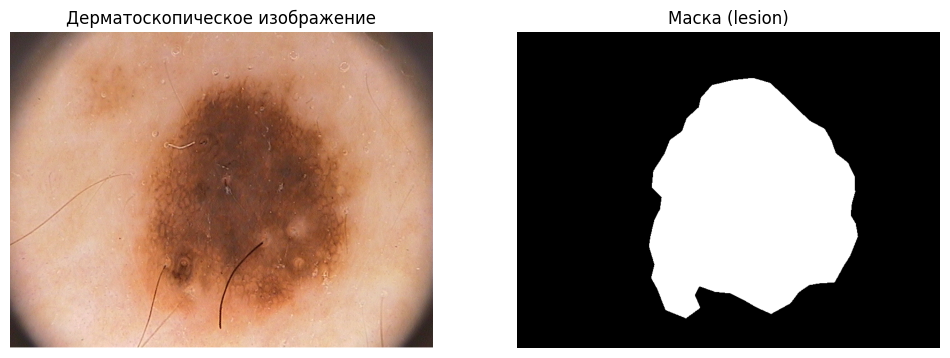

In [3]:
image = cv2.imread(image_paths[0])  
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
mask = cv2.imread(mask_paths[0], cv2.IMREAD_GRAYSCALE)  

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("–î–µ—Ä–º–∞—Ç–æ—Å–∫–æ–ø–∏—á–µ—Å–∫–æ–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("–ú–∞—Å–∫–∞ (lesion)")
plt.axis("off")

plt.show()


### 2) –°–æ–∑–¥–∞–Ω–∏–µ –¥–∞—Ç–∞—Å–µ—Ç–∞

In [4]:
IMG_SIZE = (256, 256)

def load_data(image_paths, mask_paths):
    images, masks = [], []
    for img_path, mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths)):
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, IMG_SIZE)
        mask = mask / 255.0

        images.append(img.transpose(2, 0, 1))
        masks.append(mask[np.newaxis, :, :])

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

X, y = load_data(image_paths=image_paths, mask_paths=mask_paths)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"–†–∞–∑–º–µ—Ä —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–π –≤—ã–±–æ—Ä–∫–∏: {len(X_train)}")
print(f"–†–∞–∑–º–µ—Ä –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–∏: {len(X_val)}")
print(f"–†–∞–∑–º–µ—Ä —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–∏: {len(X_test)}")

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 200/200 [00:05<00:00, 35.42it/s]


–†–∞–∑–º–µ—Ä —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–π –≤—ã–±–æ—Ä–∫–∏: 120
–†–∞–∑–º–µ—Ä –≤–∞–ª–∏–¥–∞—Ü–∏–æ–Ω–Ω–æ–π –≤—ã–±–æ—Ä–∫–∏: 40
–†–∞–∑–º–µ—Ä —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–∏: 40


In [ ]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, p=0.5),
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensorV2()
])

class PH2Dataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        image = image.astype('uint8')
        mask = mask.astype('uint8')

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        mask = mask.float()
        return image, mask

train_dataset = PH2Dataset(X_train, y_train, transform=train_transform)
val_dataset = PH2Dataset(X_val, y_val, transform=val_test_transform)
test_dataset = PH2Dataset(X_test, y_test, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### 3) –ú–æ–¥–µ–ª—å ‚Ññ1

In [7]:
class SimpleSegNet(nn.Module):
    def __init__(self):
        super(SimpleSegNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2), 
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x


### 4) –ú–æ–¥–µ–ª—å ‚Ññ2

In [8]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()

        self.conv1 = self.double_conv(3, 32)
        self.conv2 = self.double_conv(32, 64)

        self.bottleneck = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.upconv2 = self.upconv(128, 64)
        self.conv2d = self.double_conv(128, 64)

        self.upconv1 = self.upconv(64, 32)
        self.conv1d = self.double_conv(64, 32)

        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.conv1(x)
        enc2 = self.conv2(F.max_pool2d(enc1, 2))

        bottleneck = self.bottleneck(F.max_pool2d(enc2, 2))

        up2 = self.upconv2(bottleneck)
        up2 = torch.cat([up2, enc2], dim=1)
        dec2 = self.conv2d(up2)

        up1 = self.upconv1(dec2)
        up1 = torch.cat([up1, enc1], dim=1)
        dec1 = self.conv1d(up1)

        return self.final_conv(dec1)

### 5) –ú–æ–¥–µ–ª—å ‚Ññ3

In [9]:
class ExtendedUNet(nn.Module):
    def __init__(self):
        super(ExtendedUNet, self).__init__()

        self.conv1 = self.double_conv(3, 32)
        self.conv2 = self.double_conv(32, 64)
        self.conv3 = self.double_conv(64, 128)
        self.conv4 = self.double_conv(128, 256)

        self.bottleneck = self.double_conv(256, 512)

        self.upconv4 = self.upconv(512, 256)
        self.conv4d = self.double_conv(512, 256)

        self.upconv3 = self.upconv(256, 128)
        self.conv3d = self.double_conv(256, 128)

        self.upconv2 = self.upconv(128, 64)
        self.conv2d = self.double_conv(128, 64)

        self.upconv1 = self.upconv(64, 32)
        self.conv1d = self.double_conv(64, 32)

        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.conv1(x)
        enc2 = self.conv2(F.max_pool2d(enc1, 2))
        enc3 = self.conv3(F.max_pool2d(enc2, 2))
        enc4 = self.conv4(F.max_pool2d(enc3, 2))

        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        up4 = self.upconv4(bottleneck)
        up4 = torch.cat([up4, enc4], dim=1)  
        dec4 = self.conv4d(up4)

        up3 = self.upconv3(dec4)
        up3 = torch.cat([up3, enc3], dim=1)
        dec3 = self.conv3d(up3)

        up2 = self.upconv2(dec3)
        up2 = torch.cat([up2, enc2], dim=1)
        dec2 = self.conv2d(up2)

        up1 = self.upconv1(dec2)
        up1 = torch.cat([up1, enc1], dim=1)
        dec1 = self.conv1d(up1)

        return self.final_conv(dec1)


### 6) –¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏

In [10]:
def evaluate(model, loader, device):
    model.eval()
    total_iou, total_dice = 0, 0
    total_samples = 0
    all_predictions = []
    all_masks = []

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            predictions = torch.sigmoid(outputs) > 0.5
            all_predictions.extend(predictions.cpu().numpy())
            all_masks.extend(masks.cpu().numpy())

            for pred, mask in zip(predictions, masks):
                pred = pred.view(-1).cpu()
                mask = mask.view(-1).cpu()

                intersection = (pred * mask).sum().item()
                union = pred.sum().item() + mask.sum().item() - intersection

                iou = intersection / (union + 1e-8)
                dice = (2 * intersection) / (pred.sum().item() + mask.sum().item() + 1e-8)

                total_iou += iou
                total_dice += dice

            total_samples += len(predictions)

    avg_iou = total_iou / total_samples
    avg_dice = total_dice / total_samples
    return avg_iou, avg_dice, all_predictions, all_masks

### 7) –†–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞

In [11]:
class EarlyStopping:
  def __init__(self, patience=5):
    self.patience = patience
    self.best_loss = None
    self.counter = 0

  def should_stop(self, val_loss):
    if self.best_loss is None or val_loss < self.best_loss:
      self.best_loss = val_loss
      self.counter = 0
    else:
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False

### 8) ModelCheckpoint

In [12]:
class ModelCheckpoint:
  def __init__(self, filepath, monitor="val_loss", mode="min", verbose=True):
    self.filepath = filepath
    self.monitor = monitor
    self.mode = mode
    self.best_score = None
    self.verbose = verbose

  def save_checkpoint(self, model, epoch, val_score):
        if self.best_score is None or (
            self.mode == 'min' and val_score < self.best_score or
            self.mode == 'max' and val_score > self.best_score
        ):
            self.best_score = val_score
            torch.save(model.state_dict(), self.filepath)
            if self.verbose:
                print(f"‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ {epoch+1} —Å {self.monitor}: {val_score:.4f}")

### 9) –¢—Ä–µ–Ω–∏—Ä–æ–≤–∫–∞ –º–æ–¥–µ–ª–∏ ‚Ññ1

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleSegNet().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

early_stopping = EarlyStopping(patience=5)
checkpoint = ModelCheckpoint(filepath='best_model.pth', monitor='val_loss', mode='min', verbose=True)

train_losses = []
val_losses = []
val_dice_scores = []
val_iou_scores = []

for epoch in range(20):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)

        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    val_iou, val_dice, _, _ = evaluate(model, val_loader, device)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_train_loss)  
    val_dice_scores.append(val_dice)
    val_iou_scores.append(val_iou)

    print(f"–≠–ø–æ—Ö–∞ [{epoch+1}/{20}], –ü–æ—Ç–µ—Ä–∏: {avg_train_loss:.4f}, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: {val_dice:.4f}, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: {val_iou:.4f}")

    checkpoint.save_checkpoint(model, epoch, avg_train_loss)

    if early_stopping.should_stop(avg_train_loss):
        print("‚úÖ –†–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞ —Å—Ä–∞–±–æ—Ç–∞–ª–∞.")
        break

model.load_state_dict(torch.load('best_model.pth'))

test_iou, test_dice, test_predictions, test_masks = evaluate(model, test_loader, device)
test_loss = avg_train_loss  
print(f"üéØ –¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ —Ç–µ—Å—Ç–µ (Dice): {test_dice:.4f}")
print(f"üéØ IOU –Ω–∞ —Ç–µ—Å—Ç–µ: {test_iou:.4f}")

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:20<00:00,  5.22s/it]


–≠–ø–æ—Ö–∞ [1/20], –ü–æ—Ç–µ—Ä–∏: 0.7318, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 1 —Å val_loss: 0.7318


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:20<00:00,  5.03s/it]


–≠–ø–æ—Ö–∞ [2/20], –ü–æ—Ç–µ—Ä–∏: 0.6505, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.4051, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.2629
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 2 —Å val_loss: 0.6505


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:18<00:00,  4.52s/it]


–≠–ø–æ—Ö–∞ [3/20], –ü–æ—Ç–µ—Ä–∏: 0.6206, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 3 —Å val_loss: 0.6206


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:18<00:00,  4.60s/it]


–≠–ø–æ—Ö–∞ [4/20], –ü–æ—Ç–µ—Ä–∏: 0.5806, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0770, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0444
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 4 —Å val_loss: 0.5806


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:17<00:00,  4.40s/it]


–≠–ø–æ—Ö–∞ [5/20], –ü–æ—Ç–µ—Ä–∏: 0.5441, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.3017, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.2142
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 5 —Å val_loss: 0.5441


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:18<00:00,  4.55s/it]


–≠–ø–æ—Ö–∞ [6/20], –ü–æ—Ç–µ—Ä–∏: 0.5319, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.6974, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.5644
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 6 —Å val_loss: 0.5319


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:17<00:00,  4.43s/it]


–≠–ø–æ—Ö–∞ [7/20], –ü–æ—Ç–µ—Ä–∏: 0.5133, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.4917, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.3834
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 7 —Å val_loss: 0.5133


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:17<00:00,  4.45s/it]


–≠–ø–æ—Ö–∞ [8/20], –ü–æ—Ç–µ—Ä–∏: 0.5377, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.7380, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.6076


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:17<00:00,  4.41s/it]


–≠–ø–æ—Ö–∞ [9/20], –ü–æ—Ç–µ—Ä–∏: 0.5163, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.6201, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.4951


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:18<00:00,  4.66s/it]


–≠–ø–æ—Ö–∞ [10/20], –ü–æ—Ç–µ—Ä–∏: 0.5478, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.6697, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.5363


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:17<00:00,  4.39s/it]


–≠–ø–æ—Ö–∞ [11/20], –ü–æ—Ç–µ—Ä–∏: 0.5372, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.7354, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.6030


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:18<00:00,  4.53s/it]


–≠–ø–æ—Ö–∞ [12/20], –ü–æ—Ç–µ—Ä–∏: 0.5266, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.5397, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.4275
‚úÖ –†–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞ —Å—Ä–∞–±–æ—Ç–∞–ª–∞.
üéØ –¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ —Ç–µ—Å—Ç–µ (Dice): 0.5411
üéØ IOU –Ω–∞ —Ç–µ—Å—Ç–µ: 0.4164


### 10) –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –¥–∞–Ω–Ω—ã—Ö

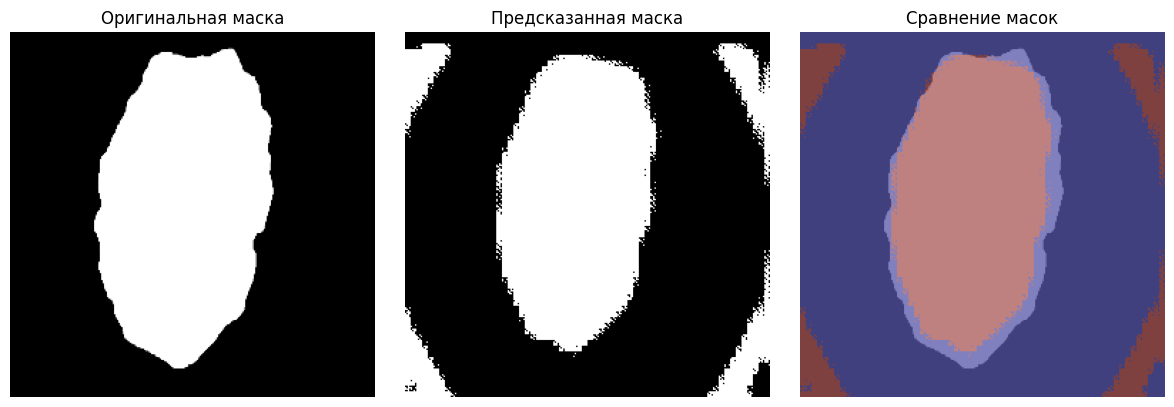

In [14]:
def visualize_predictions(predictions, masks):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(masks[10].squeeze(), cmap='gray')
    plt.title('–û—Ä–∏–≥–∏–Ω–∞–ª—å–Ω–∞—è –º–∞—Å–∫–∞')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(predictions[10].squeeze(), cmap='gray')
    plt.title('–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω–∞—è –º–∞—Å–∫–∞')
    plt.axis('off')


    plt.subplot(1, 3, 3)
    plt.imshow(masks[10].squeeze(), cmap='gray', alpha=0.5)
    plt.imshow(predictions[10].squeeze(), cmap='jet', alpha=0.5)
    plt.title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–∞—Å–æ–∫')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(test_predictions, test_masks)

### 11) –ì—Ä–∞—Ñ–∏–∫ —Ñ—É–Ω–∫—Ü–∏–∏ –ø–æ—Ç–µ—Ä—å

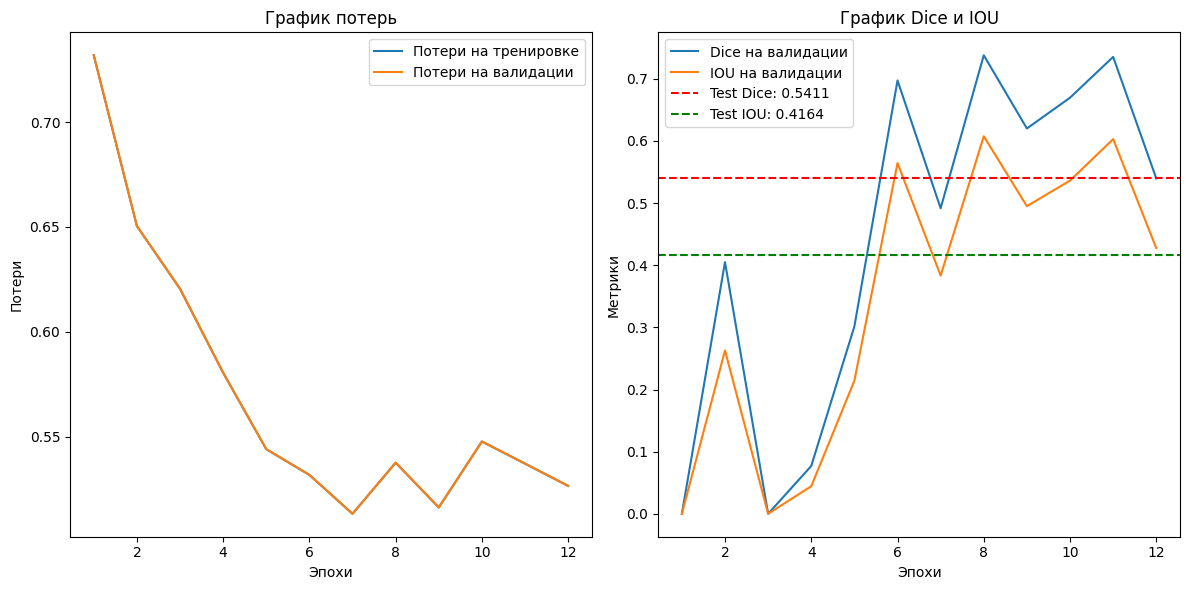

In [15]:
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='–ü–æ—Ç–µ—Ä–∏ –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–∫–µ')
plt.plot(epochs_range, val_losses, label='–ü–æ—Ç–µ—Ä–∏ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏')
plt.xlabel('–≠–ø–æ—Ö–∏')
plt.ylabel('–ü–æ—Ç–µ—Ä–∏')
plt.title('–ì—Ä–∞—Ñ–∏–∫ –ø–æ—Ç–µ—Ä—å')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_dice_scores, label='Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏')
plt.plot(epochs_range, val_iou_scores, label='IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏')
plt.axhline(y=test_dice, color='r', linestyle='--', label=f'Test Dice: {test_dice:.4f}')
plt.axhline(y=test_iou, color='g', linestyle='--', label=f'Test IOU: {test_iou:.4f}')
plt.xlabel('–≠–ø–æ—Ö–∏')
plt.ylabel('–ú–µ—Ç—Ä–∏–∫–∏')
plt.title('–ì—Ä–∞—Ñ–∏–∫ Dice –∏ IOU')
plt.legend()

plt.tight_layout()
plt.show()

### 12) –¢—Ä–µ–Ω–∏—Ä–æ–≤–∫–∞ –º–æ–¥–µ–ª–∏ ‚Ññ2

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleUNet().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

early_stopping = EarlyStopping(patience=5)
checkpoint = ModelCheckpoint(filepath='best_model.pth', monitor='val_loss', mode='min', verbose=True)

train_losses = []
val_losses = []
val_dice_scores = []
val_iou_scores = []

for epoch in range(20):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)

        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    val_iou, val_dice, _, _ = evaluate(model, val_loader, device)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_train_loss)  
    val_dice_scores.append(val_dice)
    val_iou_scores.append(val_iou)

    print(f"–≠–ø–æ—Ö–∞ [{epoch+1}/{20}], –ü–æ—Ç–µ—Ä–∏: {avg_train_loss:.4f}, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: {val_dice:.4f}, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: {val_iou:.4f}")

    checkpoint.save_checkpoint(model, epoch, avg_train_loss)

    if early_stopping.should_stop(avg_train_loss):
        print("‚úÖ –†–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞ —Å—Ä–∞–±–æ—Ç–∞–ª–∞.")
        break

model.load_state_dict(torch.load('best_model.pth'))

test_iou, test_dice, test_predictions, test_masks = evaluate(model, test_loader, device)
test_loss = avg_train_loss  
print(f"üéØ –¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ —Ç–µ—Å—Ç–µ (Dice): {test_dice:.4f}")
print(f"üéØ IOU –Ω–∞ —Ç–µ—Å—Ç–µ: {test_iou:.4f}")

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:34<00:00,  8.56s/it]


–≠–ø–æ—Ö–∞ [1/20], –ü–æ—Ç–µ—Ä–∏: 0.6881, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 1 —Å val_loss: 0.6881


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:32<00:00,  8.12s/it]


–≠–ø–æ—Ö–∞ [2/20], –ü–æ—Ç–µ—Ä–∏: 0.6768, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 2 —Å val_loss: 0.6768


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:31<00:00,  7.90s/it]


–≠–ø–æ—Ö–∞ [3/20], –ü–æ—Ç–µ—Ä–∏: 0.6191, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 3 —Å val_loss: 0.6191


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:31<00:00,  7.89s/it]


–≠–ø–æ—Ö–∞ [4/20], –ü–æ—Ç–µ—Ä–∏: 0.6245, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:31<00:00,  7.85s/it]


–≠–ø–æ—Ö–∞ [5/20], –ü–æ—Ç–µ—Ä–∏: 0.6222, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:31<00:00,  7.81s/it]


–≠–ø–æ—Ö–∞ [6/20], –ü–æ—Ç–µ—Ä–∏: 0.6072, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 6 —Å val_loss: 0.6072


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:31<00:00,  7.91s/it]


–≠–ø–æ—Ö–∞ [7/20], –ü–æ—Ç–µ—Ä–∏: 0.6148, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:31<00:00,  7.89s/it]


–≠–ø–æ—Ö–∞ [8/20], –ü–æ—Ç–µ—Ä–∏: 0.6024, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 8 —Å val_loss: 0.6024


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:34<00:00,  8.70s/it]


–≠–ø–æ—Ö–∞ [9/20], –ü–æ—Ç–µ—Ä–∏: 0.5956, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 9 —Å val_loss: 0.5956


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:33<00:00,  8.40s/it]


–≠–ø–æ—Ö–∞ [10/20], –ü–æ—Ç–µ—Ä–∏: 0.5859, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 10 —Å val_loss: 0.5859


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:35<00:00,  8.88s/it]


–≠–ø–æ—Ö–∞ [11/20], –ü–æ—Ç–µ—Ä–∏: 0.5812, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 11 —Å val_loss: 0.5812


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:34<00:00,  8.64s/it]


–≠–ø–æ—Ö–∞ [12/20], –ü–æ—Ç–µ—Ä–∏: 0.5667, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 12 —Å val_loss: 0.5667


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:33<00:00,  8.30s/it]


–≠–ø–æ—Ö–∞ [13/20], –ü–æ—Ç–µ—Ä–∏: 0.5496, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 13 —Å val_loss: 0.5496


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:32<00:00,  8.08s/it]


–≠–ø–æ—Ö–∞ [14/20], –ü–æ—Ç–µ—Ä–∏: 0.5639, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:33<00:00,  8.46s/it]


–≠–ø–æ—Ö–∞ [15/20], –ü–æ—Ç–µ—Ä–∏: 0.5395, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 15 —Å val_loss: 0.5395


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:33<00:00,  8.36s/it]


–≠–ø–æ—Ö–∞ [16/20], –ü–æ—Ç–µ—Ä–∏: 0.5427, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:32<00:00,  8.12s/it]


–≠–ø–æ—Ö–∞ [17/20], –ü–æ—Ç–µ—Ä–∏: 0.5454, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:36<00:00,  9.02s/it]


–≠–ø–æ—Ö–∞ [18/20], –ü–æ—Ç–µ—Ä–∏: 0.5400, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:37<00:00,  9.28s/it]


–≠–ø–æ—Ö–∞ [19/20], –ü–æ—Ç–µ—Ä–∏: 0.5357, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 19 —Å val_loss: 0.5357


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:34<00:00,  8.54s/it]


–≠–ø–æ—Ö–∞ [20/20], –ü–æ—Ç–µ—Ä–∏: 0.5269, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0011, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0005
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 20 —Å val_loss: 0.5269
üéØ –¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ —Ç–µ—Å—Ç–µ (Dice): 0.0015
üéØ IOU –Ω–∞ —Ç–µ—Å—Ç–µ: 0.0007


### 13) –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –¥–∞–Ω–Ω—ã—Ö

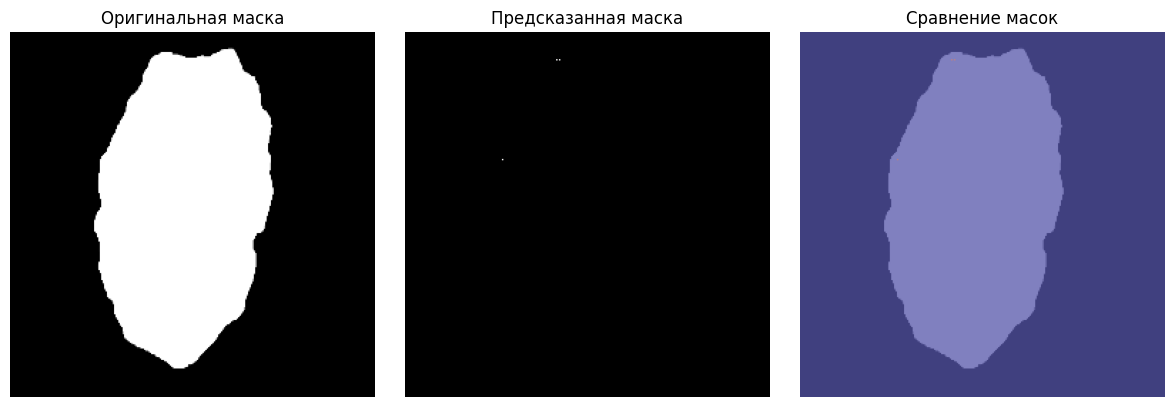

In [17]:
def visualize_predictions(predictions, masks):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(masks[10].squeeze(), cmap='gray')
    plt.title('–û—Ä–∏–≥–∏–Ω–∞–ª—å–Ω–∞—è –º–∞—Å–∫–∞')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(predictions[10].squeeze(), cmap='gray')
    plt.title('–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω–∞—è –º–∞—Å–∫–∞')
    plt.axis('off')


    plt.subplot(1, 3, 3)
    plt.imshow(masks[10].squeeze(), cmap='gray', alpha=0.5)
    plt.imshow(predictions[10].squeeze(), cmap='jet', alpha=0.5)
    plt.title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–∞—Å–æ–∫')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(test_predictions, test_masks)

### 14) –ì—Ä–∞—Ñ–∏–∫ —Ñ—É–Ω–∫—Ü–∏–∏ –ø–æ—Ç–µ—Ä—å

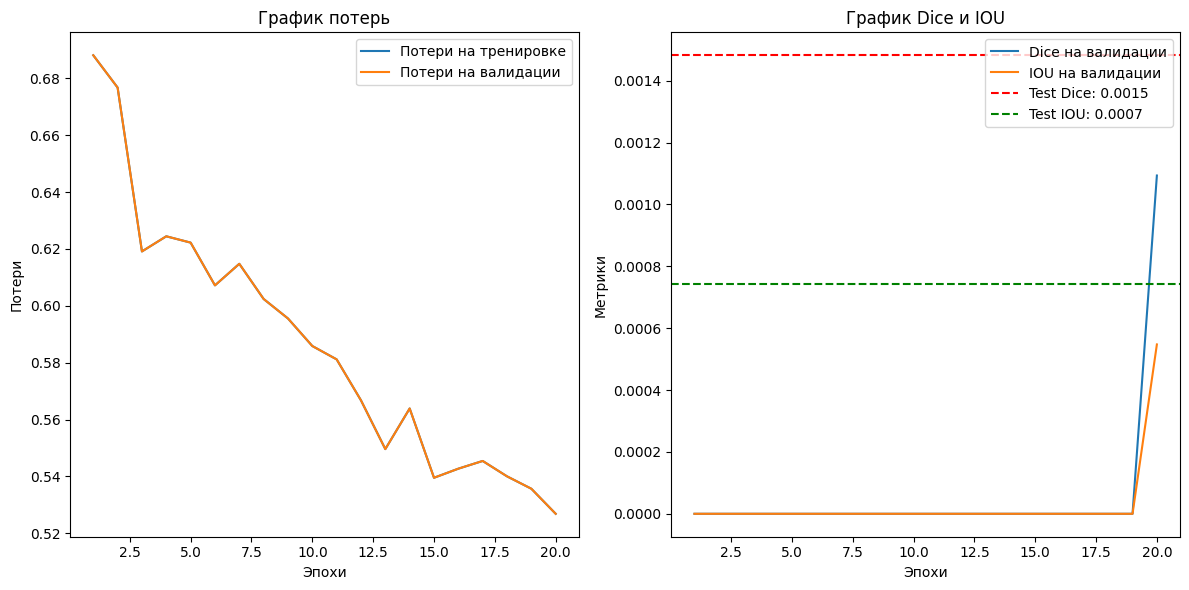

In [18]:
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='–ü–æ—Ç–µ—Ä–∏ –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–∫–µ')
plt.plot(epochs_range, val_losses, label='–ü–æ—Ç–µ—Ä–∏ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏')
plt.xlabel('–≠–ø–æ—Ö–∏')
plt.ylabel('–ü–æ—Ç–µ—Ä–∏')
plt.title('–ì—Ä–∞—Ñ–∏–∫ –ø–æ—Ç–µ—Ä—å')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_dice_scores, label='Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏')
plt.plot(epochs_range, val_iou_scores, label='IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏')
plt.axhline(y=test_dice, color='r', linestyle='--', label=f'Test Dice: {test_dice:.4f}')
plt.axhline(y=test_iou, color='g', linestyle='--', label=f'Test IOU: {test_iou:.4f}')
plt.xlabel('–≠–ø–æ—Ö–∏')
plt.ylabel('–ú–µ—Ç—Ä–∏–∫–∏')
plt.title('–ì—Ä–∞—Ñ–∏–∫ Dice –∏ IOU')
plt.legend()

plt.tight_layout()
plt.show()

### 15) –¢—Ä–µ–Ω–∏—Ä–æ–≤–∫–∞ –º–æ–¥–µ–ª–∏ ‚Ññ3

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ExtendedUNet().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

early_stopping = EarlyStopping(patience=5)
checkpoint = ModelCheckpoint(filepath='best_model.pth', monitor='val_loss', mode='min', verbose=True)

train_losses = []
val_losses = []
val_dice_scores = []
val_iou_scores = []

for epoch in range(20):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)

        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    val_iou, val_dice, _, _ = evaluate(model, val_loader, device)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_train_loss)  
    val_dice_scores.append(val_dice)
    val_iou_scores.append(val_iou)

    print(f"–≠–ø–æ—Ö–∞ [{epoch+1}/{20}], –ü–æ—Ç–µ—Ä–∏: {avg_train_loss:.4f}, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: {val_dice:.4f}, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: {val_iou:.4f}")

    checkpoint.save_checkpoint(model, epoch, avg_train_loss)

    if early_stopping.should_stop(avg_train_loss):
        print("‚úÖ –†–∞–Ω–Ω—è—è –æ—Å—Ç–∞–Ω–æ–≤–∫–∞ —Å—Ä–∞–±–æ—Ç–∞–ª–∞.")
        break

model.load_state_dict(torch.load('best_model.pth'))

test_iou, test_dice, test_predictions, test_masks = evaluate(model, test_loader, device)
test_loss = avg_train_loss  
print(f"üéØ –¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ —Ç–µ—Å—Ç–µ (Dice): {test_dice:.4f}")
print(f"üéØ IOU –Ω–∞ —Ç–µ—Å—Ç–µ: {test_iou:.4f}")

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:55<00:00, 13.93s/it]


–≠–ø–æ—Ö–∞ [1/20], –ü–æ—Ç–µ—Ä–∏: 0.6975, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0020, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0010
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 1 —Å val_loss: 0.6975


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:50<00:00, 12.54s/it]


–≠–ø–æ—Ö–∞ [2/20], –ü–æ—Ç–µ—Ä–∏: 0.6595, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 2 —Å val_loss: 0.6595


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:50<00:00, 12.62s/it]


–≠–ø–æ—Ö–∞ [3/20], –ü–æ—Ç–µ—Ä–∏: 0.6592, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 3 —Å val_loss: 0.6592


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:52<00:00, 13.05s/it]


–≠–ø–æ—Ö–∞ [4/20], –ü–æ—Ç–µ—Ä–∏: 0.6094, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 4 —Å val_loss: 0.6094


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:53<00:00, 13.30s/it]


–≠–ø–æ—Ö–∞ [5/20], –ü–æ—Ç–µ—Ä–∏: 0.5725, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 5 —Å val_loss: 0.5725


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:49<00:00, 12.44s/it]


–≠–ø–æ—Ö–∞ [6/20], –ü–æ—Ç–µ—Ä–∏: 0.5564, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 6 —Å val_loss: 0.5564


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:49<00:00, 12.32s/it]


–≠–ø–æ—Ö–∞ [7/20], –ü–æ—Ç–µ—Ä–∏: 0.5388, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.0000
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 7 —Å val_loss: 0.5388


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:49<00:00, 12.44s/it]


–≠–ø–æ—Ö–∞ [8/20], –ü–æ—Ç–µ—Ä–∏: 0.5030, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.2078, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.1400
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 8 —Å val_loss: 0.5030


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:53<00:00, 13.50s/it]


–≠–ø–æ—Ö–∞ [9/20], –ü–æ—Ç–µ—Ä–∏: 0.4828, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.6131, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.4867
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 9 —Å val_loss: 0.4828


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [01:01<00:00, 15.34s/it]


–≠–ø–æ—Ö–∞ [10/20], –ü–æ—Ç–µ—Ä–∏: 0.4641, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.6564, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.5384
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 10 —Å val_loss: 0.4641


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:58<00:00, 14.51s/it]


–≠–ø–æ—Ö–∞ [11/20], –ü–æ—Ç–µ—Ä–∏: 0.4493, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.6991, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.5864
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 11 —Å val_loss: 0.4493


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:56<00:00, 14.10s/it]


–≠–ø–æ—Ö–∞ [12/20], –ü–æ—Ç–µ—Ä–∏: 0.4991, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.6081, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.4949


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [01:06<00:00, 16.55s/it]


–≠–ø–æ—Ö–∞ [13/20], –ü–æ—Ç–µ—Ä–∏: 0.4727, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.7059, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.5761


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [01:07<00:00, 16.99s/it]


–≠–ø–æ—Ö–∞ [14/20], –ü–æ—Ç–µ—Ä–∏: 0.4572, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.6783, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.5510


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [01:04<00:00, 16.06s/it]


–≠–ø–æ—Ö–∞ [15/20], –ü–æ—Ç–µ—Ä–∏: 0.4388, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.6510, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.5294
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 15 —Å val_loss: 0.4388


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [01:12<00:00, 18.22s/it]


–≠–ø–æ—Ö–∞ [16/20], –ü–æ—Ç–µ—Ä–∏: 0.4336, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.7027, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.5766
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 16 —Å val_loss: 0.4336


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [01:08<00:00, 17.06s/it]


–≠–ø–æ—Ö–∞ [17/20], –ü–æ—Ç–µ—Ä–∏: 0.4120, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.6998, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.5698
‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –Ω–∞ —ç–ø–æ—Ö–µ 17 —Å val_loss: 0.4120


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [01:14<00:00, 18.69s/it]


–≠–ø–æ—Ö–∞ [18/20], –ü–æ—Ç–µ—Ä–∏: 0.5334, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.4127, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.3121


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [01:13<00:00, 18.26s/it]


–≠–ø–æ—Ö–∞ [19/20], –ü–æ—Ç–µ—Ä–∏: 0.5033, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.5599, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.4445


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [01:12<00:00, 18.19s/it]


–≠–ø–æ—Ö–∞ [20/20], –ü–æ—Ç–µ—Ä–∏: 0.4361, Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.6908, IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.5570
üéØ –¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ —Ç–µ—Å—Ç–µ (Dice): 0.6652
üéØ IOU –Ω–∞ —Ç–µ—Å—Ç–µ: 0.5300


### 16) –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –¥–∞–Ω–Ω—ã—Ö

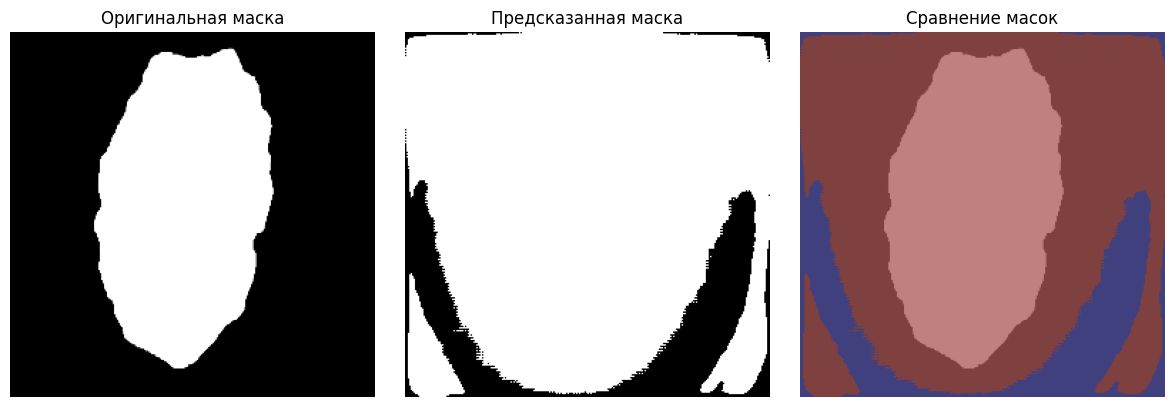

In [15]:
def visualize_predictions(predictions, masks):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(masks[10].squeeze(), cmap='gray')
    plt.title('–û—Ä–∏–≥–∏–Ω–∞–ª—å–Ω–∞—è –º–∞—Å–∫–∞')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(predictions[10].squeeze(), cmap='gray')
    plt.title('–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω–∞—è –º–∞—Å–∫–∞')
    plt.axis('off')


    plt.subplot(1, 3, 3)
    plt.imshow(masks[10].squeeze(), cmap='gray', alpha=0.5)
    plt.imshow(predictions[10].squeeze(), cmap='jet', alpha=0.5)
    plt.title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–∞—Å–æ–∫')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(test_predictions, test_masks)

### 17) –ì—Ä–∞—Ñ–∏–∫ —Ñ—É–Ω–∫—Ü–∏–∏ –ø–æ—Ç–µ—Ä—å

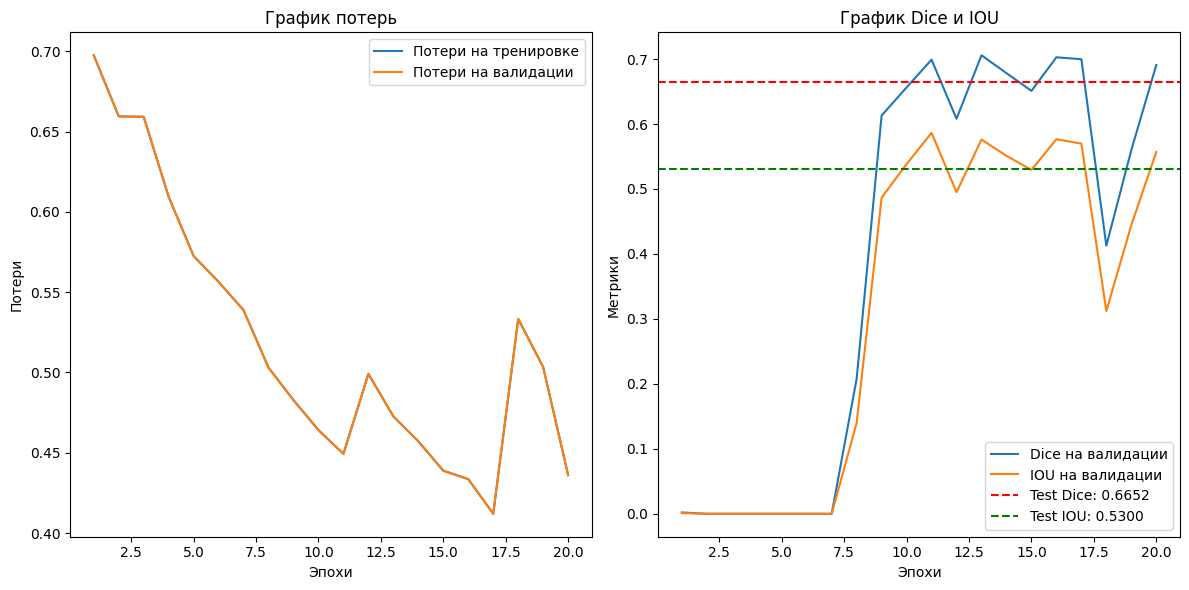

In [16]:
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='–ü–æ—Ç–µ—Ä–∏ –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–∫–µ')
plt.plot(epochs_range, val_losses, label='–ü–æ—Ç–µ—Ä–∏ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏')
plt.xlabel('–≠–ø–æ—Ö–∏')
plt.ylabel('–ü–æ—Ç–µ—Ä–∏')
plt.title('–ì—Ä–∞—Ñ–∏–∫ –ø–æ—Ç–µ—Ä—å')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_dice_scores, label='Dice –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏')
plt.plot(epochs_range, val_iou_scores, label='IOU –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏')
plt.axhline(y=test_dice, color='r', linestyle='--', label=f'Test Dice: {test_dice:.4f}')
plt.axhline(y=test_iou, color='g', linestyle='--', label=f'Test IOU: {test_iou:.4f}')
plt.xlabel('–≠–ø–æ—Ö–∏')
plt.ylabel('–ú–µ—Ç—Ä–∏–∫–∏')
plt.title('–ì—Ä–∞—Ñ–∏–∫ Dice –∏ IOU')
plt.legend()

plt.tight_layout()
plt.show()